In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os

## Input Data Information

In [2]:
shops = pd.read_csv("data/shops.csv")
item_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")

test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

shops

In [3]:
print('# shops')
shops.head(3)

# shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [4]:
shops.nunique()

shop_name    60
shop_id      60
dtype: int64

In [5]:
shops.isna().sum()

shop_name    0
shop_id      0
dtype: int64

item_categories

In [6]:
print('# item_categories')
print('Number of duplicates: %d' % len(item_categories[item_categories.duplicated()]))
item_categories.head(3)

# item_categories
Number of duplicates: 0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [7]:
item_categories.nunique()

item_category_name    84
item_category_id      84
dtype: int64

In [8]:
item_categories.isna().sum()

item_category_name    0
item_category_id      0
dtype: int64

items

In [9]:
print('# items')
print('Number of duplicates: %d' % len(items[items.duplicated()]))
items.head(3)

# items
Number of duplicates: 0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [10]:
items.nunique()

item_name           22170
item_id             22170
item_category_id       84
dtype: int64

In [11]:
items.isna().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [12]:
print('# sales_train')
print('Number of duplicates: %d' % len(sales_train[sales_train.duplicated()]))
sales_train.head()

# sales_train
Number of duplicates: 6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


These are NOT true "duplicates". There can be many people buying the same item on the same day.

In [13]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [14]:
print("# The last record in the training set")
sales_train.iloc[-1, :]

# The last record in the training set


date              03.10.2015
date_block_num            33
shop_id                   25
item_id                 7460
item_price               299
item_cnt_day               1
Name: 2935848, dtype: object

In [15]:
print('# test')
print('Number of duplicates: %d' % len(test[test.duplicated()]))
test.head(2)

# test
Number of duplicates: 0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [16]:
test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [17]:
test.isna().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [18]:
# Create lists for the item_id and shop_id to be predicted
item_id_test_list = list(test['item_id'].unique())
shop_id_test_list = list(test['shop_id'].unique())

Let's make a master dataframe containing all the information

In [19]:
train_master = sales_train.merge(items, on='item_id').merge(shops, on='shop_id').merge(item_categories, on='item_category_id')
train_master['city'] = train_master['shop_name'].str.split(' ').map(lambda x : x[0])
train_master.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль


## Exploratory Data Analysis (EDA)

### Item / Shop Distribution

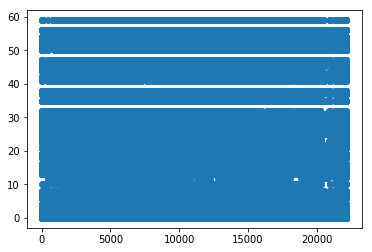

In [20]:
# Item / Shop Distribution for the first and the last month

df = sales_train[sales_train.date_block_num == 0][['item_id', 'shop_id']]
plt.scatter(df['item_id'], df['shop_id'])

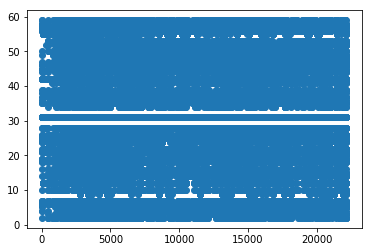

In [21]:
df = sales_train[sales_train.date_block_num == 33][['item_id', 'shop_id']]
plt.scatter(df['item_id'], df['shop_id'])

Conclusion: There seems to be items not sold in certain shops and shops not selling things in certain months. Therefore, shop_id, item_id, and item_cateogory_id will be three of the features.

### Total number of sold items vs. item_id

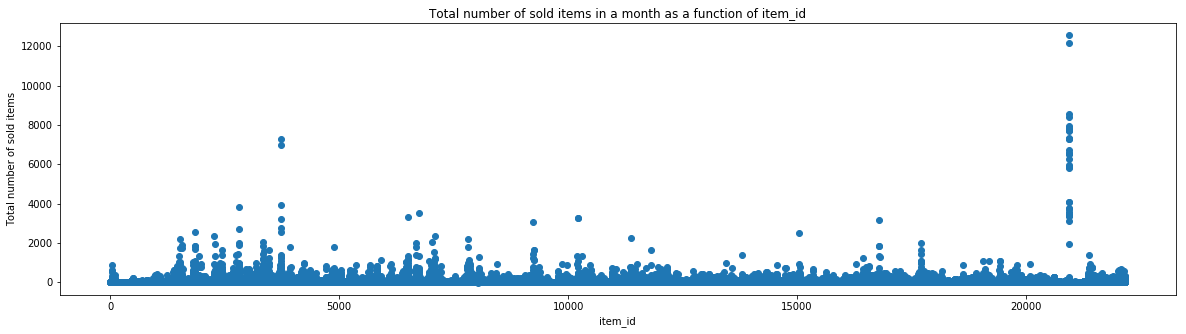

In [22]:
# First compute the total number of sold items for each item_id

df = sales_train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day' : ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

plt.figure(figsize=(20, 5))
plt.scatter(df.item_id, df.item_cnt_sum)
plt.title("Total number of sold items in a month as a function of item_id")
plt.xlabel("item_id")
plt.ylabel("Total number of sold items")
plt.show()

We found an "outlier"! There is one item that has been sold way more than others. Let's look into it.

In [23]:
id_max, total_item_max = df.item_cnt_sum.idxmax(), df.item_cnt_sum.max()
item_id_max = df.loc[id_max].item_id
print("The outlier item. item_id = %d; sold %d times" % (item_id_max, int(total_item_max)))

The outlier item. item_id = 20949; sold 12557 times


In [24]:
# Whether this item_id is in the test set

item_id_max in item_id_test_list

True

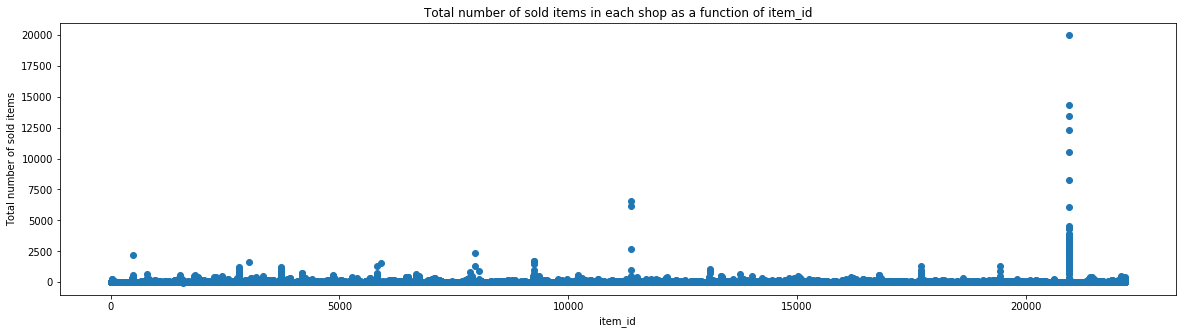

In [25]:
# Then compute the total number of sold items for each item_id for each shop

df = sales_train.groupby(['shop_id', 'item_id']).agg({'item_cnt_day' : ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

plt.figure(figsize=(20, 5))
plt.scatter(df.item_id, df.item_cnt_sum)
plt.title("Total number of sold items in each shop as a function of item_id")
plt.xlabel("item_id")
plt.ylabel("Total number of sold items")
plt.show()

We learn from the above plot that different shops lead to different sales.

### Total number of sold items vs. time

Let's use item_id = 20949 (the most sold item, or "outlier") as an example to look at how sales go with time

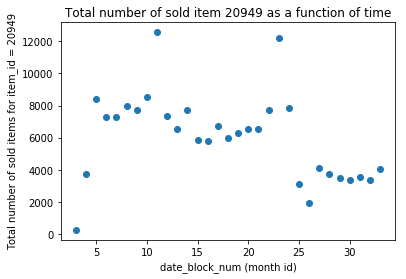

In [26]:
df = sales_train[sales_train.item_id == 20949].groupby(['date_block_num']).agg({'item_cnt_day' : ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

plt.scatter(df.date_block_num, df.item_cnt_sum)
plt.title("Total number of sold item 20949 as a function of time")
plt.xlabel("date_block_num (month id)")
plt.ylabel("Total number of sold items for item_id = 20949")
plt.show()

Looks good! So we keep this "outlier". This item is simply a popular one.

We see two peaks. Let's see what months are these

In [27]:
df[df.item_cnt_sum > 10000]

,date_block_num,item_cnt_sum
8,11,12557.0
20,23,12185.0


It's November!!!!! Keep in mind that we are trying to predict November as well

### Conclusion: item_id related features <br>
- item_id
- shop_id
- name of the item
- last month's sale
- last year's sale
- whether is on promotion

### Total number of sold items vs. item_category

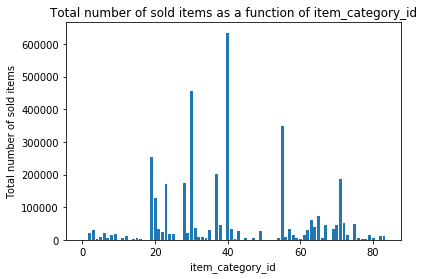

In [28]:
df = train_master.groupby(['item_category_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']
plt.bar(df.index, df.item_cnt_sum)
plt.title("Total number of sold items as a function of item_category_id")
plt.xlabel("item_category_id")
plt.ylabel("Total number of sold items")
plt.show()

Let's look at this plot as a function of time

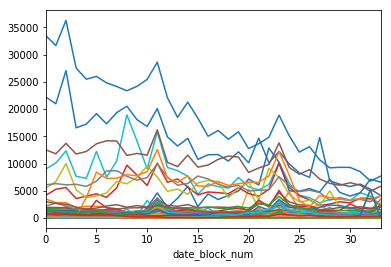

In [29]:
df = train_master.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']

df = df.unstack('item_category_id').loc[:].fillna(0)

df.plot(legend=False)

It looks like the economy is not doing well. The sale declined quite a bit as it approached 2015

Let's now try to compute the number of sold items vs item_category for different months, as a box plot

In [30]:
df = train_master.groupby(['date_block_num','item_category_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)
df.head(2)

,date_block_num,item_category_id,item_cnt_sum
0,0,0,1.0
1,0,1,1.0


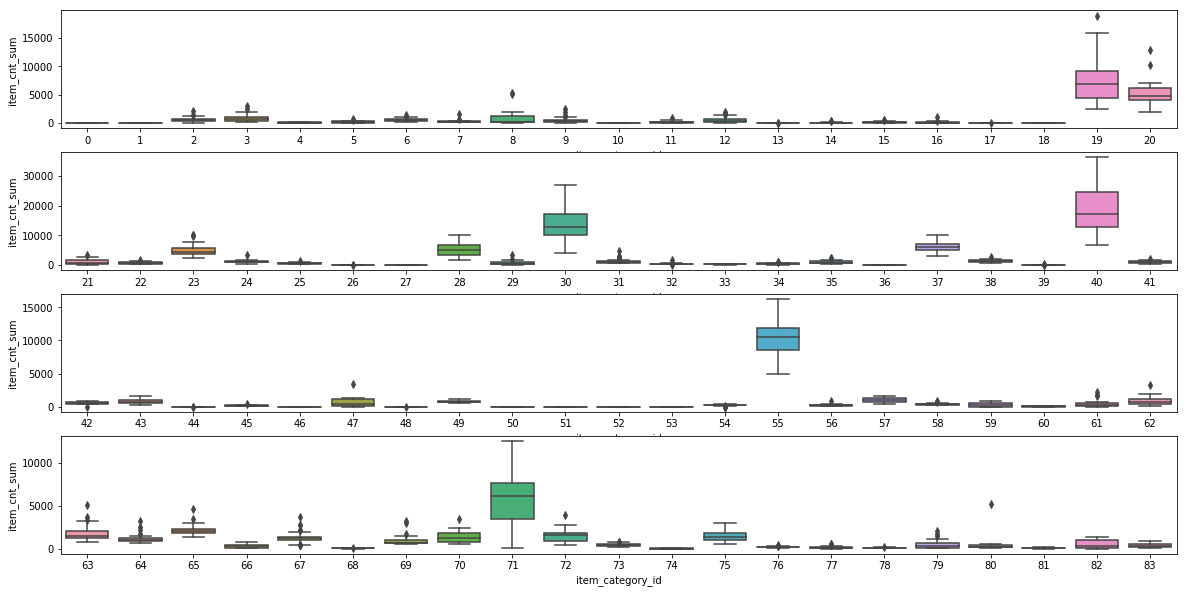

In [31]:
# Visualize the data

f, axes = plt.subplots(4, 1, figsize=(20,10))

for i in range(4):
    sns.boxplot(data=df[(df.item_category_id >= i * 21) & (df.item_category_id < (i + 1)*21)], 
                x='item_category_id', y='item_cnt_sum', ax=axes[i])

We found a few item categories that are extremely popular. Let's compute who they are

In [32]:
df = df.groupby(['item_category_id']).agg({'item_cnt_sum': ['median']})
df.columns = ['item_cnt_median']
df.sort_values('item_cnt_median',ascending=False, inplace=True)
df.reset_index(inplace=True)
df.head()

,item_category_id,item_cnt_median
0,40,17192.0
1,30,12715.0
2,55,10492.5
3,19,6846.5
4,71,6131.0


In [33]:
top_item_list = list(df[df.index < 10].item_category_id)
print("The top selling item categories are: \n")
print(top_item_list)

The top selling item categories are: 

[40, 30, 55, 19, 71, 37, 28, 20, 23, 65]


### Conclusion: category related features <br>
- item_category_id
- last month's sale for the same item_category_id
- last year's sale for the same item_category_id

### Total number of sold items vs. shop_id

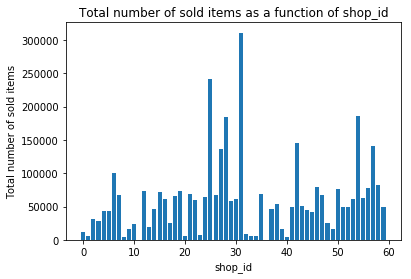

In [34]:
# Compute the total number of sold items for each shop_id

df = sales_train.groupby(['shop_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']

plt.bar(df.index, df.item_cnt_sum)
plt.title("Total number of sold items as a function of shop_id")
plt.xlabel("shop_id")
plt.ylabel("Total number of sold items")
plt.show()

There are a few shops that are doing great, and a few that are not doing so.

Let's make a correlation between sales and the city where the shop is in

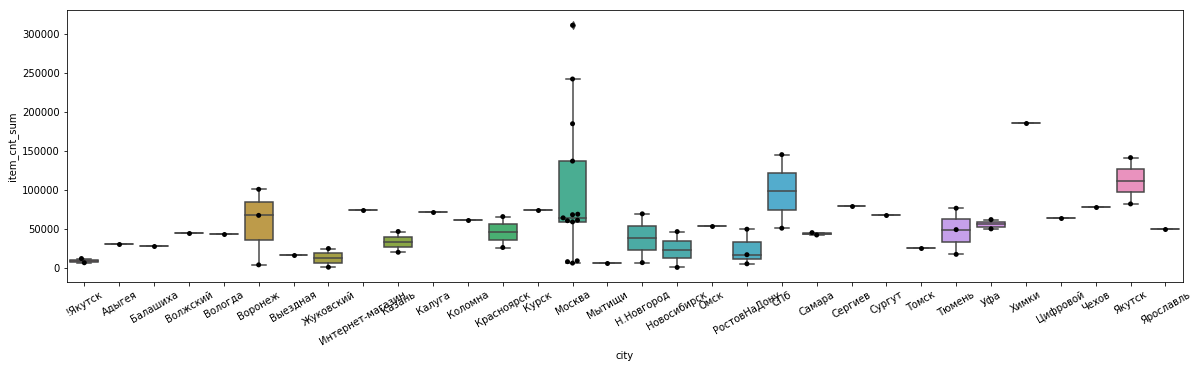

In [35]:
df = train_master.groupby(['city', 'shop_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

f, ax = plt.subplots(1, 1, figsize=(20,5))
sns.boxplot(data=df, x='city', y='item_cnt_sum', ax=ax)
sns.swarmplot(data=df, x='city', y='item_cnt_sum', color='black', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

There is a slight correlation between city and the sales. BTW, The city in the middle of the above box plot is Moscow!

### Conclusion: shop related features <br>
- shop_id
- city
- last month's shop revenue
- last year's shop revenue

### Price Histogram

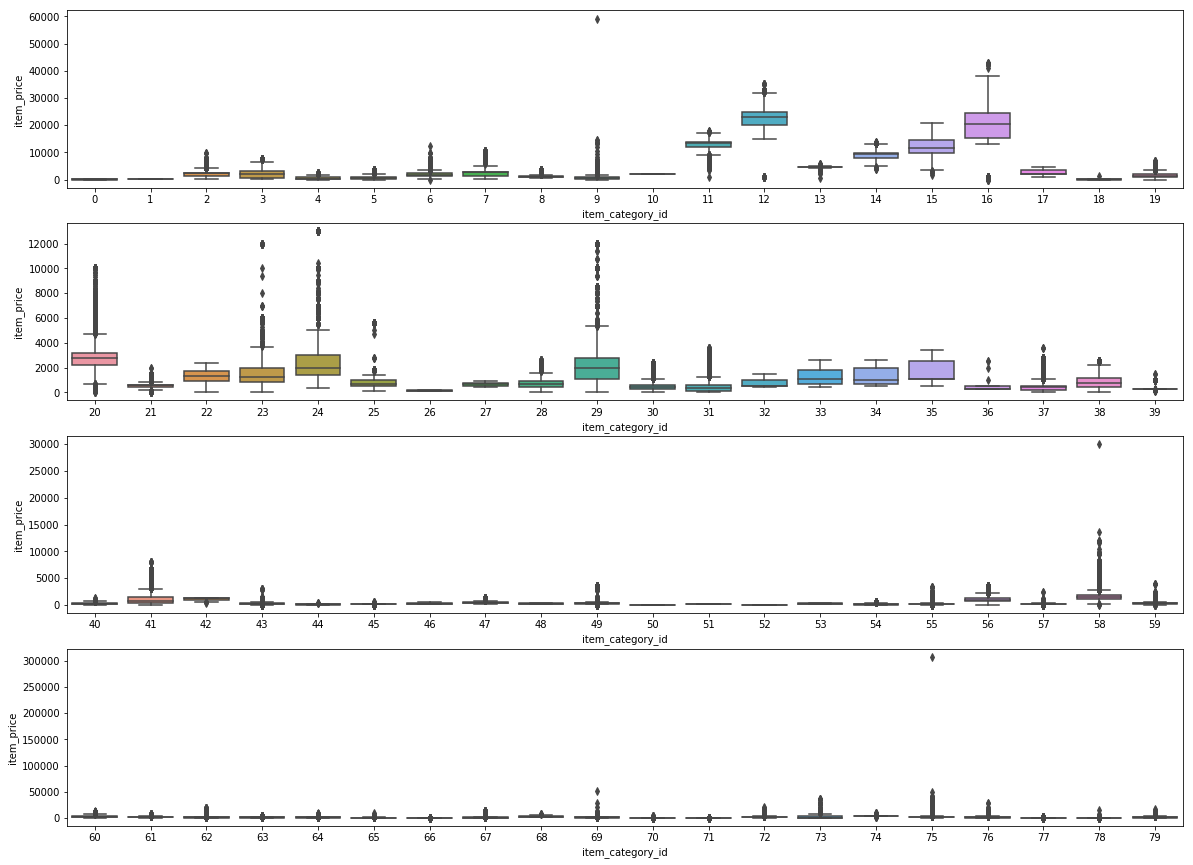

In [36]:
f, axes = plt.subplots(4, 1, figsize=(20,15))

for i in range(4):
    sns.boxplot(data=train_master[(train_master.item_category_id >= i * 20) & (train_master.item_category_id < (i + 1)*20)], 
                x='item_category_id', y='item_price', ax=axes[i])

### Price correlation with Sales

In [37]:
df = train_master.groupby(['date_block_num', 'item_id']).agg({'item_price':['median'],'item_cnt_day':['sum']})
df.columns = ['item_price_mean', 'item_cnt_sum']
df.reset_index(inplace=True)
df.head(2)

,date_block_num,item_id,item_price_mean,item_cnt_sum
0,0,19,28.0,1.0
1,0,27,2499.0,7.0


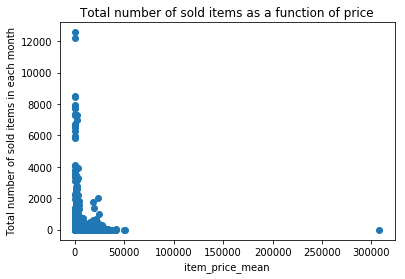

In [38]:
plt.scatter(df.item_price_mean, df.item_cnt_sum)
plt.title("Total number of sold items as a function of price")
plt.xlabel("item_price_mean")
plt.ylabel("Total number of sold items in each month")
plt.show()

There is one "outlier" on the right. let's take a closer look into the left part by zooming in

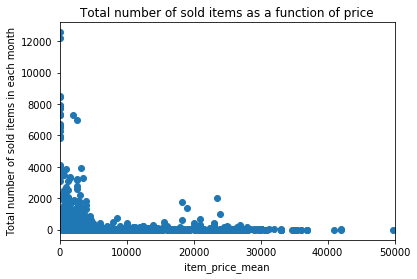

In [39]:
plt.scatter(df.item_price_mean, df.item_cnt_sum)
plt.title("Total number of sold items as a function of price")
plt.xlabel("item_price_mean")
plt.ylabel("Total number of sold items in each month")
plt.xlim([0, 50000])
plt.show()

Looks like a Pareto plot! It makes a lot of sense. The price can be a powerful feature in predicting the sales

### Conclusion: price related features <br>
- item_price
- last month's item_price
- last year's item_price

### Outdated Items

In [40]:
# Compute items that are not sold in the last twelve months

df = sales_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                            columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
df.columns = df.columns.droplevel().map(str)
df = df.reset_index(drop=True).rename_axis(None, axis=1)
df.columns.values[0] = 'item_id'
df.head()

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
outdated_items = list(df[df.loc[:, '22':].sum(axis=1)==0]['item_id'])
print("There are %d outdated items" % len(outdated_items))

There are 9638 outdated items


That's a lot!!! Since items are outdated, we can just put ZERO into the prediction of these items.

### Conclusion: outdatedness related features <br>
- whether the item is outdated